<h1>Подбор нового тарифа</h1>

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали. Необходимо построить модель с максимально большим значением accuracy.

**Описание данных:**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  

**План работы**: первым делом мы посмотрим на данные, которые получили, затем поделим выборку на обучающую, валидационную и тестовую, далее мы обучим несколько моделей: будем менять гиперпараметры, чтобы подобрать лучшую модель, и наконец, проверим избранную на вменяемость, а также посмотрим качество на тестовой выборке.

<h3>Оглавление</h3>

1. [Шаг 1: Знакомство с данными, разделение на выборки](#samples)
2. [Шаг 2: Исследование качества различных моделей](#models)
3. [Шаг 3: Проверка качества на тестовой выборке и проверка на вменяемость](#test_sanity)

<h3>Шаг 1: Знакомство с данными, разделение на выборки</h3>
<a id='samples'></a>

Первым делом импортируем необходимые нам для работы библиотеки, функции и классы.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

Прочитаем предоставленные нам данные в переменную data. Вызовем метод info для просмотра общей информации о датафрейме и взглядем на первые пять строк - ознакомимся таким образом с данными.

In [2]:
data = pd.read_csv('datasets/users_behavior.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Мы бегло ознакомились с данными, более подробно и не требуется - все уже предобработано. 

Сразу можно сказать: наш целевой признак - столбец is_ultra, отделим его от остального набора. Получим в отдельных переменных признаки и целевой признак.

In [4]:
target = data['is_ultra']
feat = data.drop(columns=['is_ultra'])

Посмотрим ближе на наши признаки, а именно, обратим внимание на взаимосвязь их между собой. Рассмотрим коэффициенты корреляции сначала.

In [5]:
feat.corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


Итак, мы видим - коэффициент корреляции между минутами и звонками практически равен единице. Это значит, что данные факторы взимозаменяемы в данной вопросе. Чтобы убедиться в своем предположении, посмотрим диаграммы рассеяния.

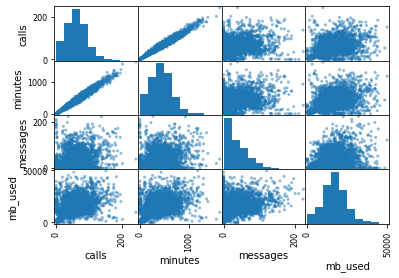

In [6]:
pd.plotting.scatter_matrix(feat)
plt.show()

Да, все верно - на диаграмме практически прямая линия - сильная взаимосвязь. Оставим что-то одно - пусть, минуты. Столбец, содержащий количество звонков использовать не будем.

In [7]:
feat = feat.drop(columns = ['calls'])

А теперь самое интересное, поделим выборку на обучающую, валидационную и тестовую. Воспользуемся train_test_split дважды. Получим такое соотношение - обучающая выборка:валидационная выборка:тестовая выборка как 3:1:1.

In [8]:
target_train, target_te, feat_train, feat_te = train_test_split(target, feat, test_size=0.4, random_state=12345 )

In [9]:
target_test, target_valid, feat_test, feat_valid = train_test_split(target_te, feat_te, test_size=0.5, random_state=12345)

Получили 6 датафреймов: три с целевым признаком и три с признаками.

**Вывод по Шагу 1**: итак, на данном Шаге мы ознакомились с полученными данными, а также разделили нашу выборку на три части: обучающую, валидационную и тестовую в соотношении 3:1:1. 

<h3>Шаг 2: Исследование качества различных моделей</h3>
<a id='models'></a>

Итак, на данном шаге нам необходимо исследовать качество различных моделей и, соответственно, выбрать лучшую из них. Вспомним, требуется решить проблему бинарной классификации. В процессе работы мы будем использовать различные алгоритмы обучения: дерево принятия решений, случайный лес, логистическую регрессию, а также будем менять гиперпараметры моделей. 

Обучать модели будем на тренировочной выборке, а accuracy смотреть по валидационной и на тренировочной.

Начнем с дерева принятия решений. Гиперпараметр, который мы будем менять - максимальная глубина, от 2 до 10. Полученные значения accuracy добавим в датафрейм и потом посмотрим ближе.

Создадим датафрейм для результатов.

In [10]:
accuracyDesTree = pd.DataFrame(columns=['max_depth', 'train_acc', 'valid_acc'])

Обучим несколько деревьев с различными гиперпараметрами в цикле и сохраним их показатели.

In [11]:
for i in range (2, 11):
    model = DecisionTreeClassifier(max_depth=i, random_state=12345)
    model.fit( feat_train, target_train)
    acc_val = model.score( feat_valid, target_valid)
    acc_train = model.score( feat_train, target_train)
    accuracyDesTree = accuracyDesTree.append({'max_depth': i, 'train_acc': acc_train , 'valid_acc':acc_val}, ignore_index=True)

Посмотрим на результат.

In [12]:
accuracyDesTree

,max_depth,train_acc,valid_acc
0,2.0,0.787863,0.774495
1,3.0,0.807573,0.779160
2,4.0,0.809647,0.780715
3,5.0,0.821577,0.788491
4,6.0,0.833506,0.776050
5,7.0,0.844917,0.796267
6,8.0,0.862552,0.780715
7,9.0,0.875519,0.783826
8,10.0,0.887967,0.771384


Построим график.

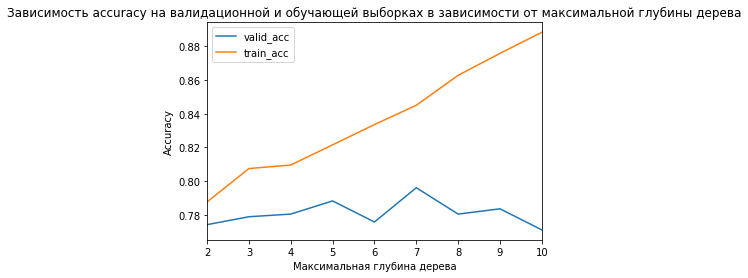

In [13]:
ax = accuracyDesTree.plot(x='max_depth', y='valid_acc')
accuracyDesTree.plot(x='max_depth', y='train_acc', ax = ax)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy на валидационной и обучающей выборках в зависимости от максимальной глубины дерева')
plt.show()

Как известно, высокое значение accuracy на валидационной выборке - это хорошо, но слишком высокое значение доли правильных ответов на обучающей выборке - нет (при условии не такого высокого значения на валидационной), поскольку сигнализирует о переобучении модели. 

Мы видим пик нашей метрики на валидационной выборке при значении гиперпараметра 'Максимальная глубина дерева' равном семи, при этом accuracy на обучающей выборке не сильно выше, что хорошо. Поэтому примем - лучшее дерево принятия решений - это дерево принятия решений с максимальной глубиной равной семи, при этом доля правильных ответов на валидационной выборке составляет 0.796. 

In [14]:
model1 = DecisionTreeClassifier(max_depth=7, random_state=12345)
model1.fit( feat_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Приступим к случайному лесу. Будем менять максимальную глубину, от 2 до 10, и количество деревьев - от 2 до 10. Для каждого количества деревьев будем оставлять одну максмальную глубину. Также будем обучать модели в цикле и сохранять результаты в датафрейме.

In [15]:
accuracyRandFor = pd.DataFrame(columns=['n_est','max_depth', 'train_acc', 'valid_acc'])

In [16]:
for i in range(2, 11):
    best_acc_valid = 0
    best_acc_train = 0
    best_depth = 0
    for j in range(2, 11):
        model = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=12345)
        model.fit(feat_train, target_train)
        acc_train = model.score(feat_train, target_train)
        acc_valid = model.score(feat_valid, target_valid)
        if (acc_valid > best_acc_valid):
            best_acc_valid = acc_valid
            best_depth = j
            best_acc_train = acc_train
    accuracyRandFor = accuracyRandFor.append({'n_est':i, 'max_depth':best_depth, 'train_acc':best_acc_train, 'valid_acc': best_acc_valid}, ignore_index=True)

Посмотрим, что получилось.

In [17]:
accuracyRandFor

,n_est,max_depth,train_acc,valid_acc
0,2.0,6.0,0.824689,0.783826
1,3.0,8.0,0.851660,0.793157
2,4.0,8.0,0.858402,0.807154
3,5.0,8.0,0.858402,0.800933
4,6.0,8.0,0.857884,0.805599
5,7.0,8.0,0.865145,0.814930
6,8.0,8.0,0.860477,0.811820
7,9.0,8.0,0.863589,0.810264
8,10.0,8.0,0.865664,0.808709


График.

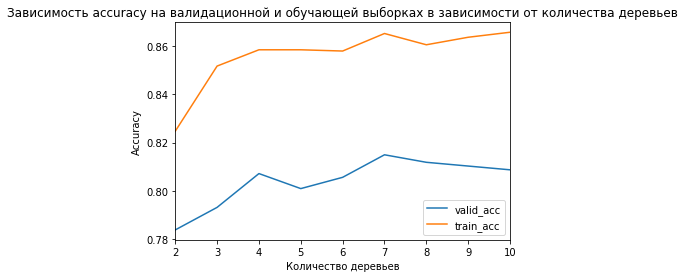

In [18]:
ax = accuracyRandFor.plot(x='n_est', y='valid_acc')
accuracyRandFor.plot(x='n_est', y='train_acc', ax = ax)
plt.xlabel('Количество деревьев')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy на валидационной и обучающей выборках в зависимости от количества деревьев')
plt.show()

В отличии от предыдущей модели, здесь нет крутого изменения метрики на тестовой выборке, да и на валидационной линия идет плавнее. Нет ярко выраженных пиков. Также интересная особенность: рост и становление accuracy на обучающей выборке с отметки '3'. Сейчас стоит выбор: взять модель с меньшей accuracy на валидационной выборке, например, 0.783 (против 0.815 максимального), но с и с меньшим значением на обучающей выборке (0.825), или взять модель с 0.815 на валидационной и 0.865 на обучающей. Возьмем второй вариант. Итак, принимаем, лучший случайный лес это случайный лес с 7 деревьями и максимальной глубиной равной 8. Доля правильных ответов для этой модели 0.815. К слову, это уже лучше дерева принятия решений.

In [23]:
model2 = RandomForestClassifier(max_depth=8, n_estimators=7, random_state=12345)
model2.fit(feat_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

Наша последняя модель - логистическая регрессия. Такую модель возьмем одну. Посмотрим на долю правильных ответов.

In [20]:
model3 = LogisticRegression(random_state=12345)
model3.fit(feat_train, target_train)
print('Accuracy на валидационной выборке:', model3.score(feat_valid, target_valid))
print('Accuracy на тестовой выборке:', model3.score(feat_train, target_train))

Accuracy на валидационной выборке: 0.6982892690513219
Accuracy на тестовой выборке: 0.7126556016597511


C:\Users\Acer\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Получили весьма интересный результат, доля правильных ответах на обеих выборках почти одинаковая, при этом низкая, ну, ниже чем у случайного леса и дерева принятия решений. 

Мы обучили множество моделей, получили значение метрики качества для каждой, сейчас можем написать вывод и, самое главное, выбрать ту самую.

**Вывод по Шагу 2**: итак, на данном этапе мы рассмотрели три различных алгоритма обучения, для двух моделей мы меняли гиперпараметры. Таким образом мы получили: лучшее дерево принятия решений - дерево с максимальной глубиной равной 7, accuracy модели 0.796; лучший случайный лес - лес с 7 деревьями с максимальной глубиной равной 8, accuracy модели 0.815; также мы посмотрели и логистическую регрессию - значение метрики качества для данной модели 0.698. Таким образом, мы получаем, что лучшая модель - это случайный лес. Поскольку в данной задаче он нас требуется лишь наиболее качественная модель - это наш ответ. Но такие стоит помнить, что случайный лес обучается дольше, чем решающее дерево или логистическая регрессия. 

<h3>Шаг 3: Проверка качества на тестовой выборке и проверка на вменяемость </h3>
<a id='test_sanity'></a>

Итак, мы выбрали нашу модель. Теперь мы проверим ее качество на тестовой выборке и проверим на вменяемость. Бонусом проверим на вменяемоесть еще две модели - лучшее дерево принятия решений и логистическую регрессию.

Проверим качество на тестовой выборке.

In [21]:
model2.score(feat_test, target_test)

0.7869362363919129

Неплохо. Получили accuracy 0.79. Теперь проверка на вменяемость.

Теперь создадим Dummy модель, которая классифицирует все объекты как объекты одного класса - наиболее встречающегося. Такая модель удобна для проверки на вменяемость. Сранивания её метрики качества с метриками созданных нами моделей, можно проверить, лучше ли работает наша модель. Если лучше, то она вменяема. 

In [22]:
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(feat_train, target_train)
dummy_acc = dummy.score(feat_valid, target_valid)
dummy_acc

0.6842923794712286

Итак, получили accuracy для dummy модели на валидационной выборке 0.684. Что меньше, чем доля правильных ответов наших лучших дерева и леса, а также логистической регрессии. Главный результат - наша избранная модель вменяема.

**Вывод по Шагу 3**: на данном этапе мы проверили качество нашей выбранной модели на тестовой выборке, а также проверили ее на вменяемость путем сравнения ее метрики качества с accuracy dummy модели. Получили результат: модель вменяема, на тестовой выборке она показала неплохой результат - не сильно более низкий, чем на валидационной выборке. Также узнали, что наше лучшее дерево принятия решений и логистическая регрессия также вменяемы.